In [49]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches


# Parametros de la grilla

In [301]:
Lx, Ly = 14, 10 #Escala 1
#Lx, Ly = 28, 20 #Escala 2
#Lx, Ly = 42, 30 #Escala 3
# Lx, Ly = 56, 40 #Escala 4
# Lx, Ly = 70, 50 #Escala 5
# Lx, Ly = 84, 60 #Escala 6

grid_size = (Lx, Ly)
Lx/Ly

1.4

# Carga de datos


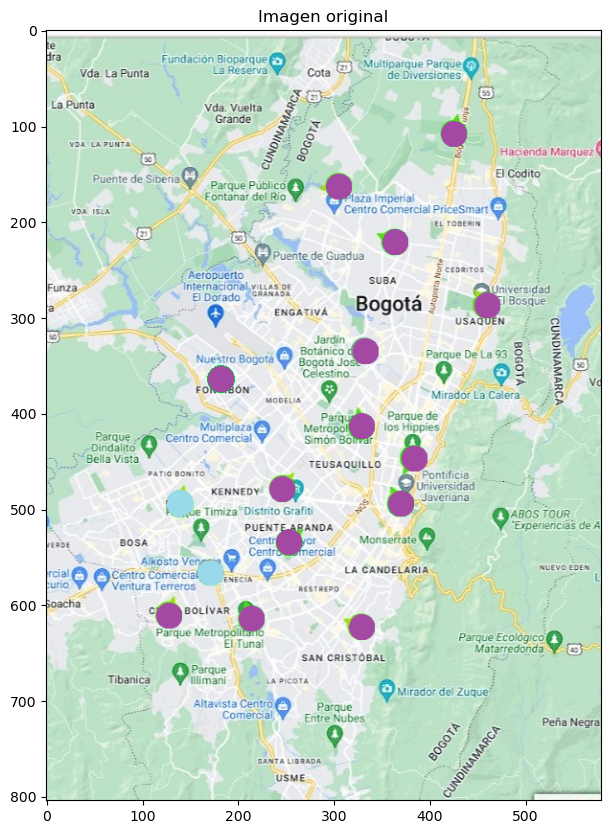

In [302]:
# image_path = '../Mapita.png'
image_path = '../Map.png'
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(image_rgb, cmap='gray')
plt.title('Imagen original')
plt.show()

# Lectura de la imagen

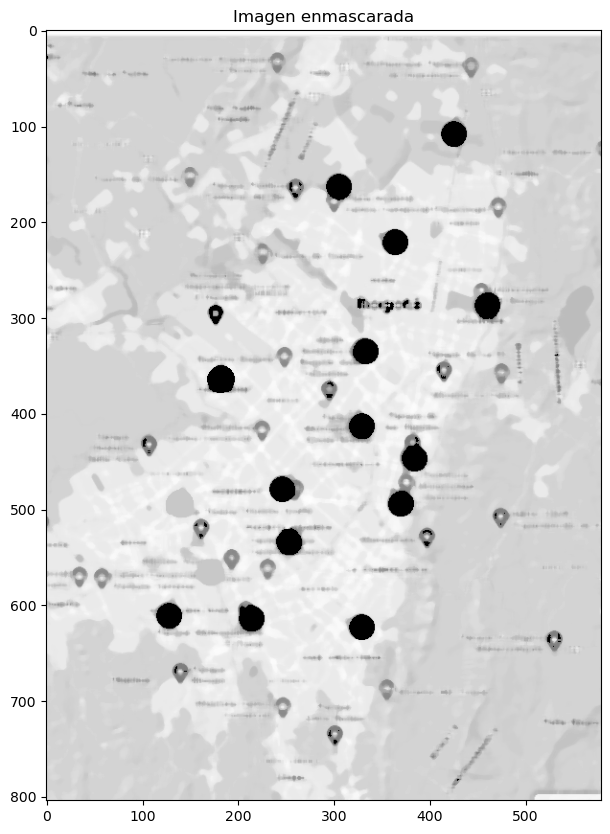

In [303]:

image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Aplicar suavizado para mejorar la detección de círculos
image_blur = cv2.medianBlur(image_gray, 7)

# Definir el rango de valores de gris oscuro
lower_gray = 125
upper_gray = 255

# Crear una máscara para los píxeles oscuros
mask = cv2.inRange(image_blur, lower_gray, upper_gray)

# Aplicar la máscara a la imagen borrosa
masked_image = cv2.bitwise_and(image_blur, image_blur, mask=mask)

# Mostrar la imagen enmascarada
plt.figure(figsize=(10, 10))
plt.imshow(masked_image, cmap='gray')
plt.title('Imagen enmascarada')
plt.show()



# Identificación de coordenadas en la grilla

Se detectaron 16 círculos.


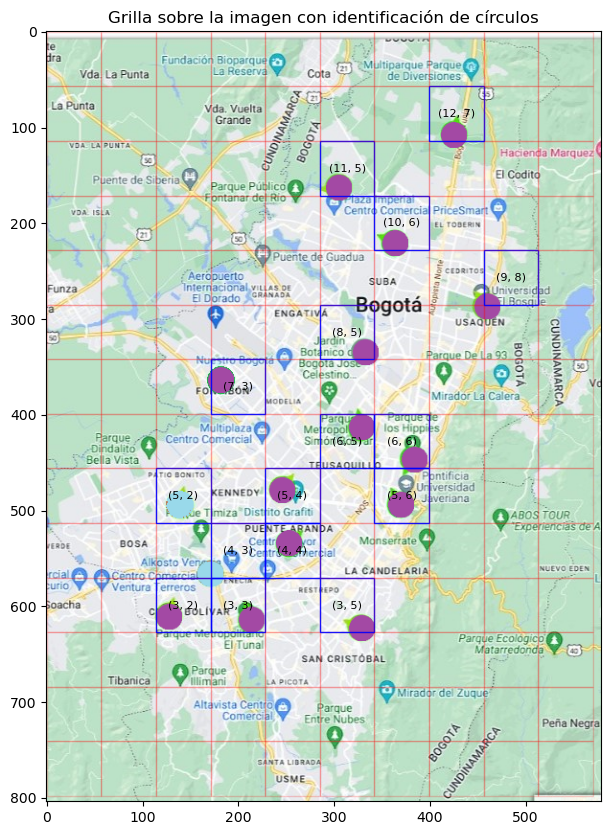

Numero de estaciones contadas: 16


In [304]:
# Detectar círculos usando la transformada de Hough
circles = cv2.HoughCircles(masked_image, cv2.HOUGH_GRADIENT, dp=1.5, minDist=20,
                           param1=50, param2=30, minRadius=13, maxRadius=21)


# Verificar si se han detectado círculos
if circles is not None:
    print(f'Se detectaron {circles.shape[1]} círculos.')
    # Redondear las coordenadas y el radio de los círculos
    circles = np.round(circles[0, :]).astype("int")
    # Crear una matriz para almacenar la grilla de posiciones de las estaciones
    height, width, _ = image.shape
    #Se definen las dimensiones de las celdas
    cell_height = height // grid_size[0]
    cell_width = width // grid_size[1]
    #Se crea la matriz de posiciones de las estaciones
    stations_positions = np.zeros(grid_size)

    # Crear una figura para visualizar la imagen y la grilla
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Procesar cada círculo detectado
    for (x, y, r) in circles:
        #Celda en la que se encuentra el círculo
        cell_x = x // cell_width
        cell_y = ((height - y)  // cell_height) 
        # print(f'Estación en la celda ({cell_y}, {cell_x})')
        
        # Marcar la celda en la grilla
        stations_positions[cell_y, cell_x] = 1

    # Colorear la grilla sobre la imagen
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            if stations_positions[i, j] == 1:
                rect = patches.Rectangle((j * cell_width, (Lx - 1 - i) * cell_height), cell_width, cell_height, linewidth=1, edgecolor='b', facecolor='none', alpha=0.9)
                ax.add_patch(rect)
                # Anotar la posición en la celda
                plt.text(j * cell_width + cell_width / 2, (Lx - 1 - i) * cell_height + cell_height / 2, f'({i}, {j})', color='black', fontsize=8, ha='center', va='center', alpha=1)
                
            else:
                rect = patches.Rectangle((j * cell_width, (Lx - 1 - i) * cell_height), cell_width, cell_height, linewidth=1, edgecolor='r', facecolor='none', alpha=0.2)
                ax.add_patch(rect)

    # Mostrar la imagen con las posiciones de los círculos y la grilla coloreada
    plt.title('Grilla sobre la imagen con identificación de círculos')
    plt.show()
    print(f'Numero de estaciones contadas: {len(stations_positions[stations_positions == 1])}')

else:
    print("No se detectaron círculos.")

# Relacionación con las estaciones reales

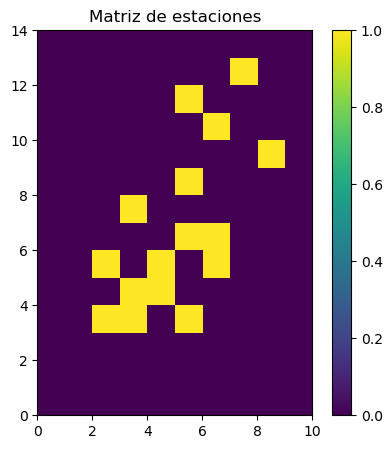

In [305]:
#Matiz de estaciones
plt.figure(figsize=(5,5))
# plt.imshow(stations_positions)
plt.imshow(stations_positions, extent=[0, Ly, 0, Lx], origin='lower')
plt.colorbar()
plt.title('Matriz de estaciones')
plt.show()

In [306]:
#Lectura de estaciones
path_data = '../estaciones.txt'
data_estaciones = pd.read_csv(path_data)
len(data_estaciones)

19

In [307]:

# Filtrar el dataset por la columna "VelViento" igual a True
data_VelViento = data_estaciones[data_estaciones['VelViento'] == True]

len(data_VelViento)

16

In [308]:
coords_X, coords_Y = [], []
# Verificar si lo siguiente es correcto
# Recorrer `stations_positions` y asignar coordenadas a los valores distintos de cero
# Estas se recorren en i de izquierda a derecha y en j de abajo hacia arriba ya
# en el dataset se encuentran las estaciones en orden de arriba hacia abajo y 
# de izquierda a derecha
for i in reversed(range(Lx)):
    for j in reversed(range(Ly)):
        if stations_positions[i, j] != 0:
            # print(f'Estación en la celda ({i}, {j})')
            coords_X.append(i)
            coords_Y.append(j)

# Asignar las coordenadas al DataFrame
data_VelViento['x_cell'] = coords_X
data_VelViento['y_cell'] = coords_Y

data_VelViento

C:\Users\cterr\AppData\Local\Temp\ipykernel_20856\1823847827.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_VelViento['x_cell'] = coords_X
C:\Users\cterr\AppData\Local\Temp\ipykernel_20856\1823847827.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_VelViento['y_cell'] = coords_Y


,Estación,VelViento,DirViento,PM10,Pm2.5,x_cell,y_cell
0,Guaymaral,True,True,True,True,12,7
1,Suba,True,True,True,True,11,5
2,Colina,True,True,True,True,10,6
4,Usaquén,True,True,True,True,9,8
5,Las Ferias,True,True,True,True,8,5
6,Fontibón,True,True,True,True,7,3
8,Centro de Alto Rendimiento,True,True,True,True,6,6
9,Móvil Séptima,True,True,True,True,6,5
10,Ministerio de Ambiente,True,True,True,True,5,6
11,Puente Aranda,True,True,True,True,5,4


In [309]:
data_VelViento.to_csv('../estaciones_coord.txt', sep=',', index=False)

In [310]:
def meters_per_pixel(pixel, distance):
    return distance/pixel

def time_per_pixel(distance):
    vel_sound = 343
    c = 1/np.sqrt(3)
    return (distance*c)/vel_sound

In [311]:
cell_height, cell_width

(57, 57)

In [312]:
scale = meters_per_pixel(52,2000)
distance_cell = cell_width*scale
print(f'Distancia de las celdas: {distance_cell} m')

Distancia de las celdas: 2192.3076923076924 m


In [313]:
time = time_per_pixel(distance_cell)
print(f'El click por celda es de {time} segundos')

El click por celda es de 3.6901732836744423 segundos


In [314]:
print(f'Cantidad de clikcs por hora: {3600/time} clicks/hora')

Cantidad de clikcs por hora: 975.563943277847 clicks/hora


In [315]:
vel_sound = 343 
c = 1/np.sqrt(3)
vel_cel = (distance_cell*c)/time
vel_sound, vel_cel

(343, 343.0)